In this notebook we show how to get all the temperature measurements and quality flags (QF) acquired by the mooring located in the Palma Bay (_Bahía de Palma_).

In [1]:
using JSON
using HTTP
using Dates
using NCDatasets
using Statistics

## Directories

In [20]:
figdir = "./figures"
isdir(figdir) ? @debug("Already exists") : mkpath(figdir);

## Request
### API key
In order to avoid hard-coding the key in the notebook, you can create a new environment variable in a terminal:
```bash
export socib_api_key=your_api_key
```
Then the variable can be accessed in Julia using 
```julia
ENV["socib_api_key"]
```

### Build the query

In [2]:
api_key = ENV["socib_api_key"]
query1 = "http://api.socib.es/entries/?page_size=100&processing_level=L1&instrument_type=Conductivity%20and%20Temperature%20Recorder&platform=Buoy_BahiaDePalma&apikey=$(api_key)&page=1"
query2 = "http://api.socib.es/entries/?page_size=100&processing_level=L1&instrument_type=Conductivity%20and%20Temperature%20Recorder&platform=Buoy_BahiaDePalma&apikey=$(api_key)&page=2"
r1 = HTTP.request("GET", query1);
r2 = HTTP.request("GET", query2);

### Convert responses to dictionaries 
Using the `JSON`module.

In [3]:
r1dict = JSON.parse(String(r1.body));
r2dict = JSON.parse(String(r2.body));
@info("Found a total of $(length(r1dict["results"])) + $(length(r2dict["results"])) entries")

┌ Info: Found a total of 100 + 15 entries
└ @ Main In[3]:3


### Build a list of URLs

In [12]:
urllist = String[]
for r in r1dict["results"]
    push!(urllist, r["services"]["opendap"]["url"])
end
for r in r2dict["results"]
    push!(urllist, r["services"]["opendap"]["url"])
end
@info("The list contains $(length(urllist)) links");

┌ Info: The list contains 115 links
└ @ Main In[12]:8


## Data reading
### Functions

We create two methods (in one function `read_temperature`) for:
1. reading the time series from a single time period (one OPeNDAP URL)
2. reading all the time series (in one go) from the full period (2012-2012, list of OPeNDAP URLs)

In [7]:
function read_temperature(dataurl::String)
    NCDatasets.Dataset(dataurl, "r") do ds
        time = NCDatasets.varbyattrib(ds, standard_name="time")[1][:]
        T = NCDatasets.varbyattrib(ds, standard_name="sea_water_temperature")[1][:]
        TQF = NCDatasets.varbyattrib(ds, standard_name="sea_water_temperature status_flag")[1][:]
        return coalesce.(time, NaN)::Vector{Dates.DateTime}, coalesce.(T, NaN)::Vector{Float64}, 
        coalesce.(TQF, NaN)::Vector{Int8}
    end
end

read_temperature (generic function with 2 methods)

In [8]:
function read_temperature(urllist::Array{String})
    datesall = Dates.DateTime[];
    Tall = Float64[]
    TQFall = Int8[]
    
    for dataurl in urllist
        dates, T, TQF = read_temperature(dataurl);
        append!(datesall, dates)
        append!(Tall, T)
        append!(TQFall, TQF)
    end
    
    return datesall, Tall, TQFall
end

read_temperature (generic function with 2 methods)

### Reading
The function is applied to the list we build in a [previous step](#Build-a-list-of-URLs)

In [13]:
@time dates, T, TQF = read_temperature(urllist);

 64.533716 seconds (1.58 M allocations: 246.942 MiB, 0.07% gc time)


Keep only data points which have QF = 1

In [14]:
T[TQF .!= 1] .= NaN;

## Plotting

We use `PyPlot`, based on Python `matplotlib`.

In [15]:
using PyPlot
const plt = PyPlot

PyPlot

If needed, specify the path of the Python you are using
```bash
ENV["PYTHON"] = "/usr/local/bin/python3.8"
```

In [16]:
using PyCall
mdates = pyimport("matplotlib.dates")

PyObject <module 'matplotlib.dates' from '/home/ctroupin/.julia/conda/3/lib/python3.7/site-packages/matplotlib/dates.py'>

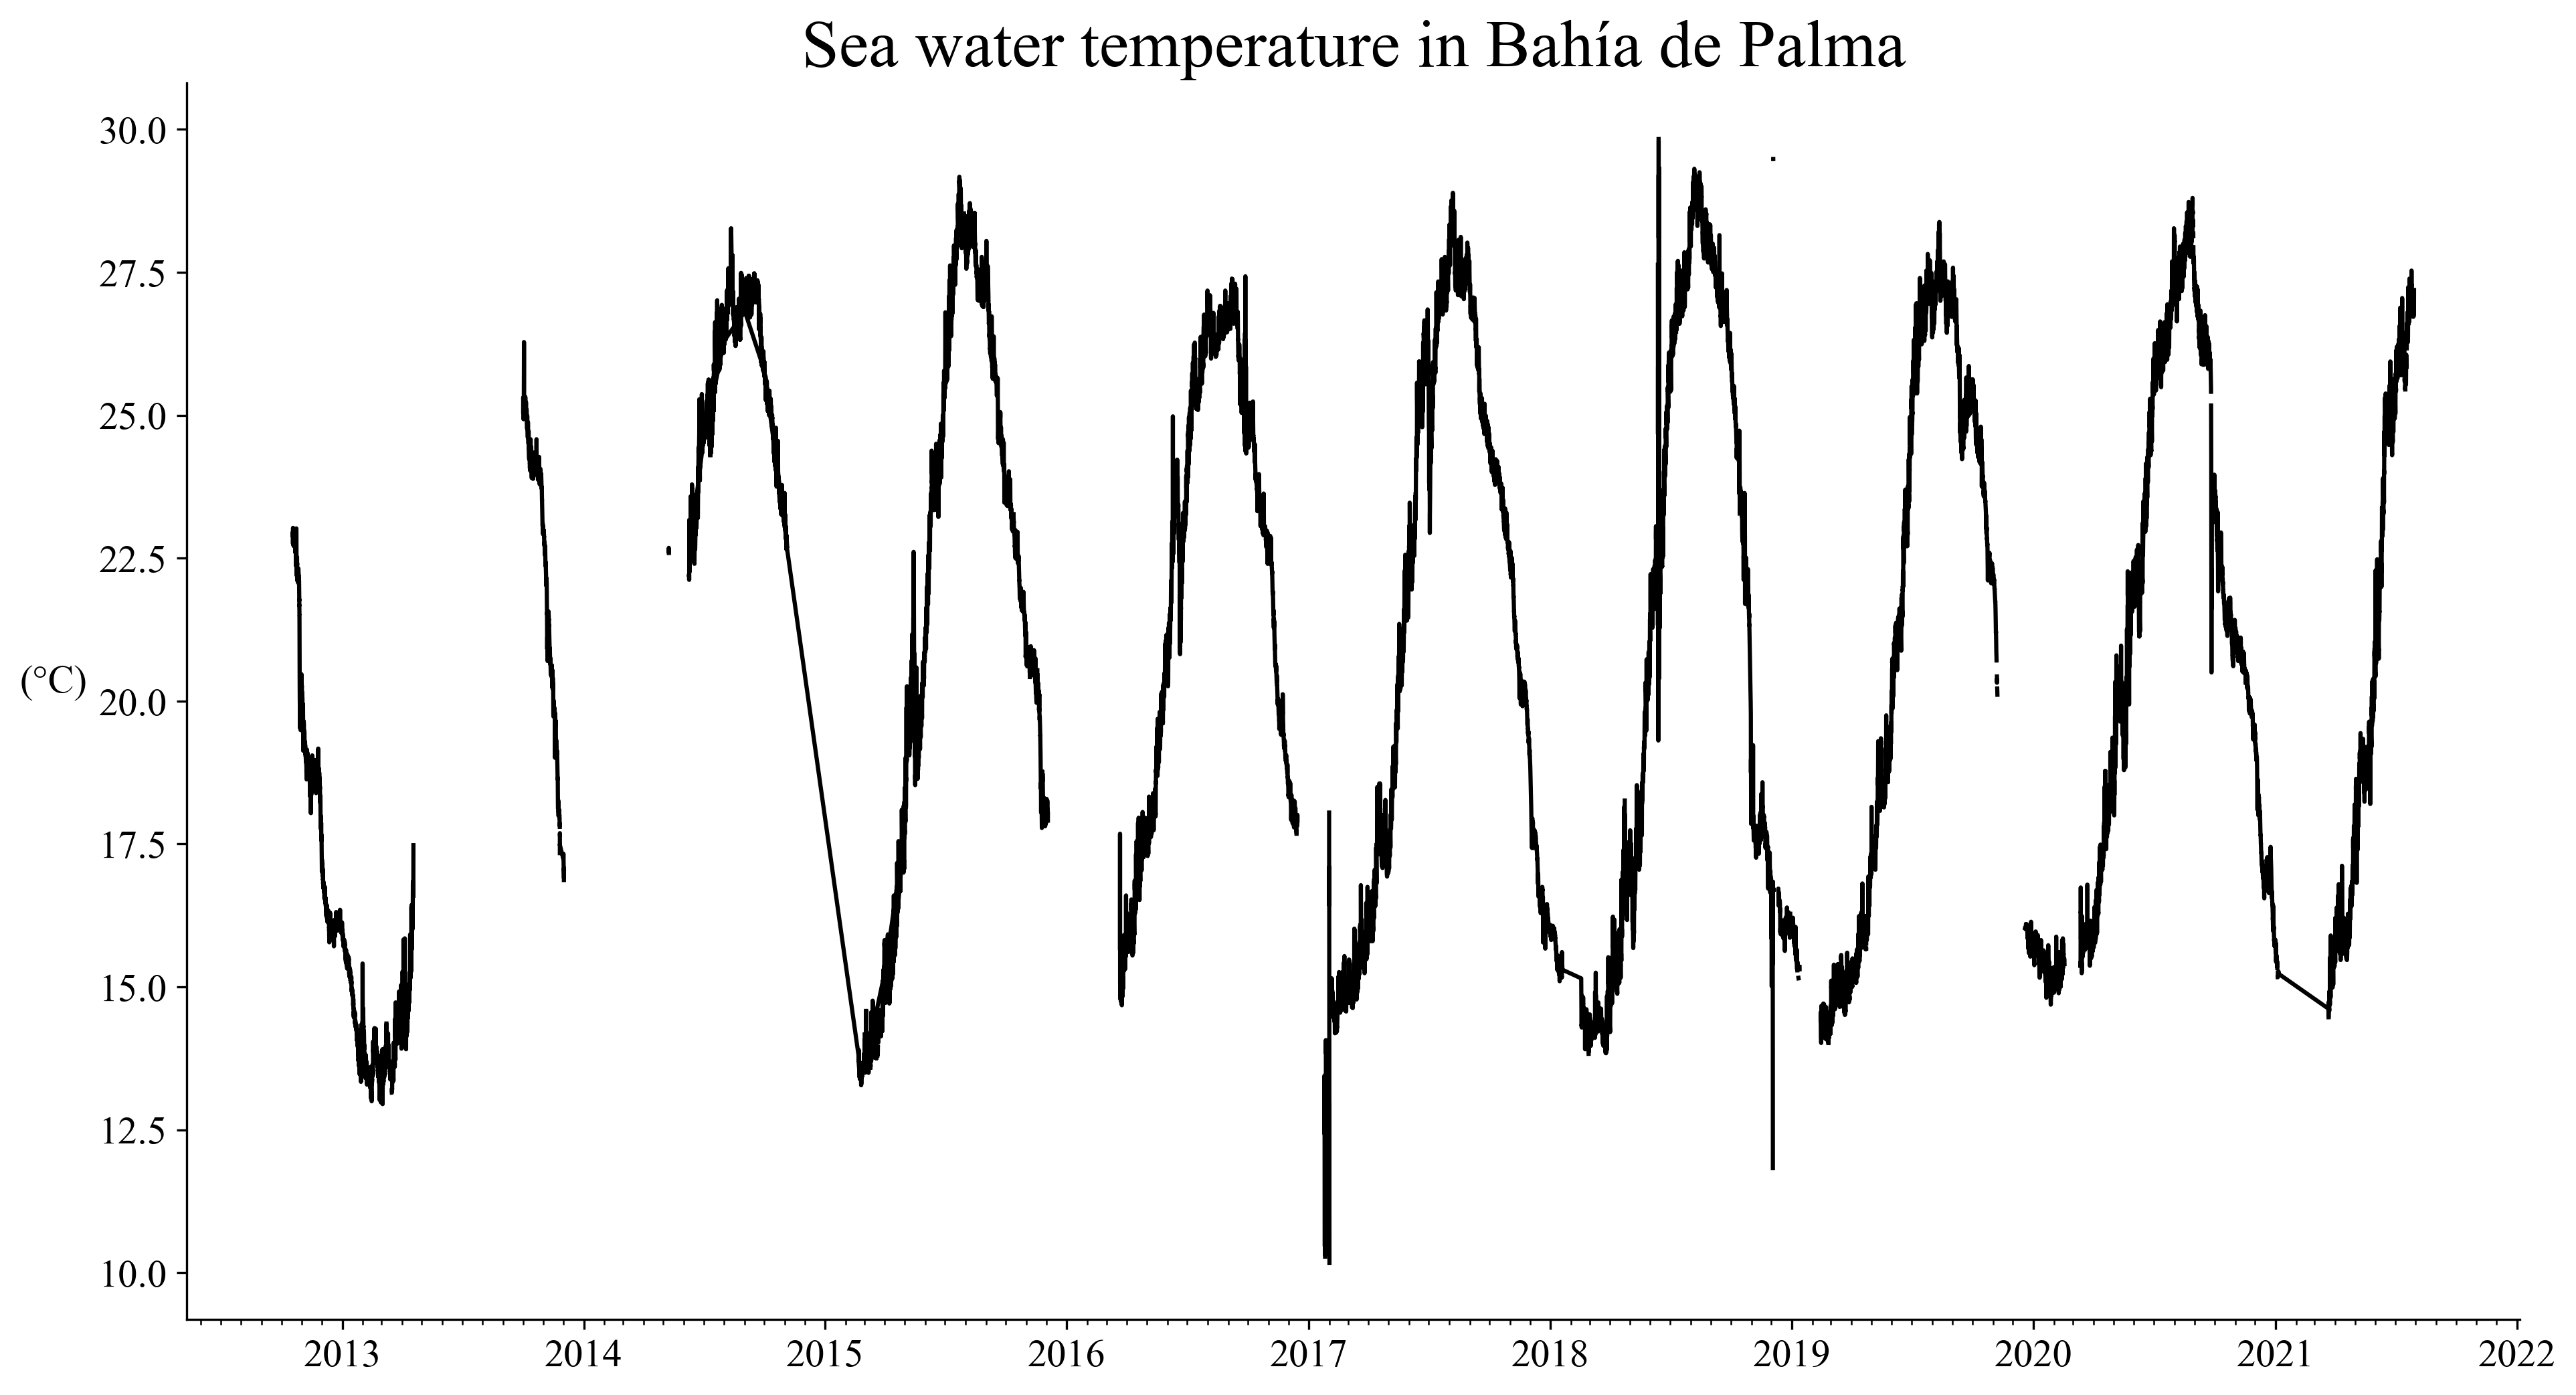

In [35]:
fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)
ax.plot(dates, T, color="k")
plt.title("Sea water temperature in Bahía de Palma", ha="center", rotation=0, fontsize=24)
plt.ylabel("(°C)", ha="right", rotation=0)
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
plt.savefig(joinpath(figdir, "temperature_bahia_V1.jpg"), dpi=300, bbox_inches="tight")
plt.show()
# plt.close()

### Year by year
Prepare new time vectors and month limits for the xticks.

In [22]:
daysyear = [(ddd - Dates.DateTime(Dates.year(ddd), 1, 1, 0, 0, 0)).value / 86400000. for ddd in dates]
yearvector = [Dates.year(ddd) for ddd in dates]
ndaysmonth = Array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
ndays = cat(1, cumsum(ndaysmonth), dims=1)
monthnames = [monthname(mm) for mm in 1:12];

Compute the annual mean

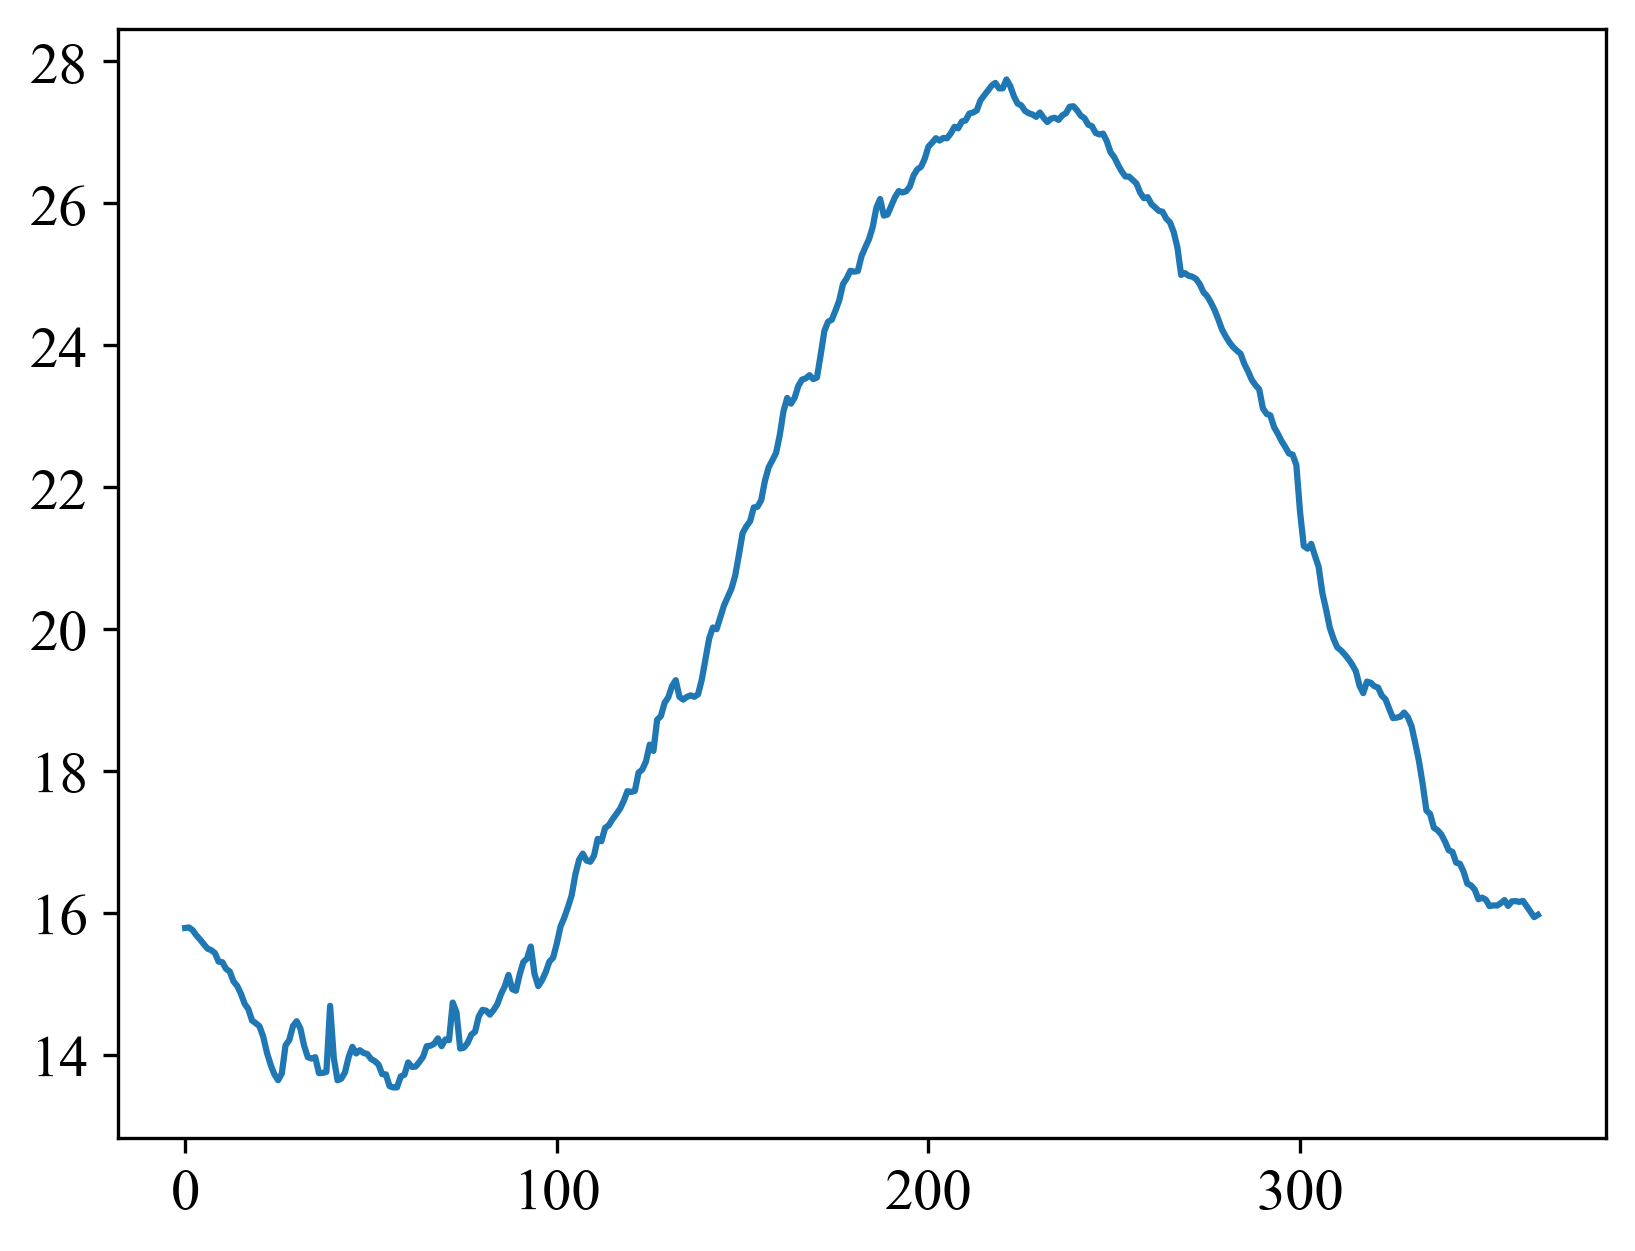

In [23]:
meanT = zeros(365)
for ii in 1:365
    goodday = findall(floor.(daysyear) .== ii)
    meanT[ii] = mean(filter(!isnan, T[goodday]))
end
plt.plot(meanT)
plt.show()

20122013

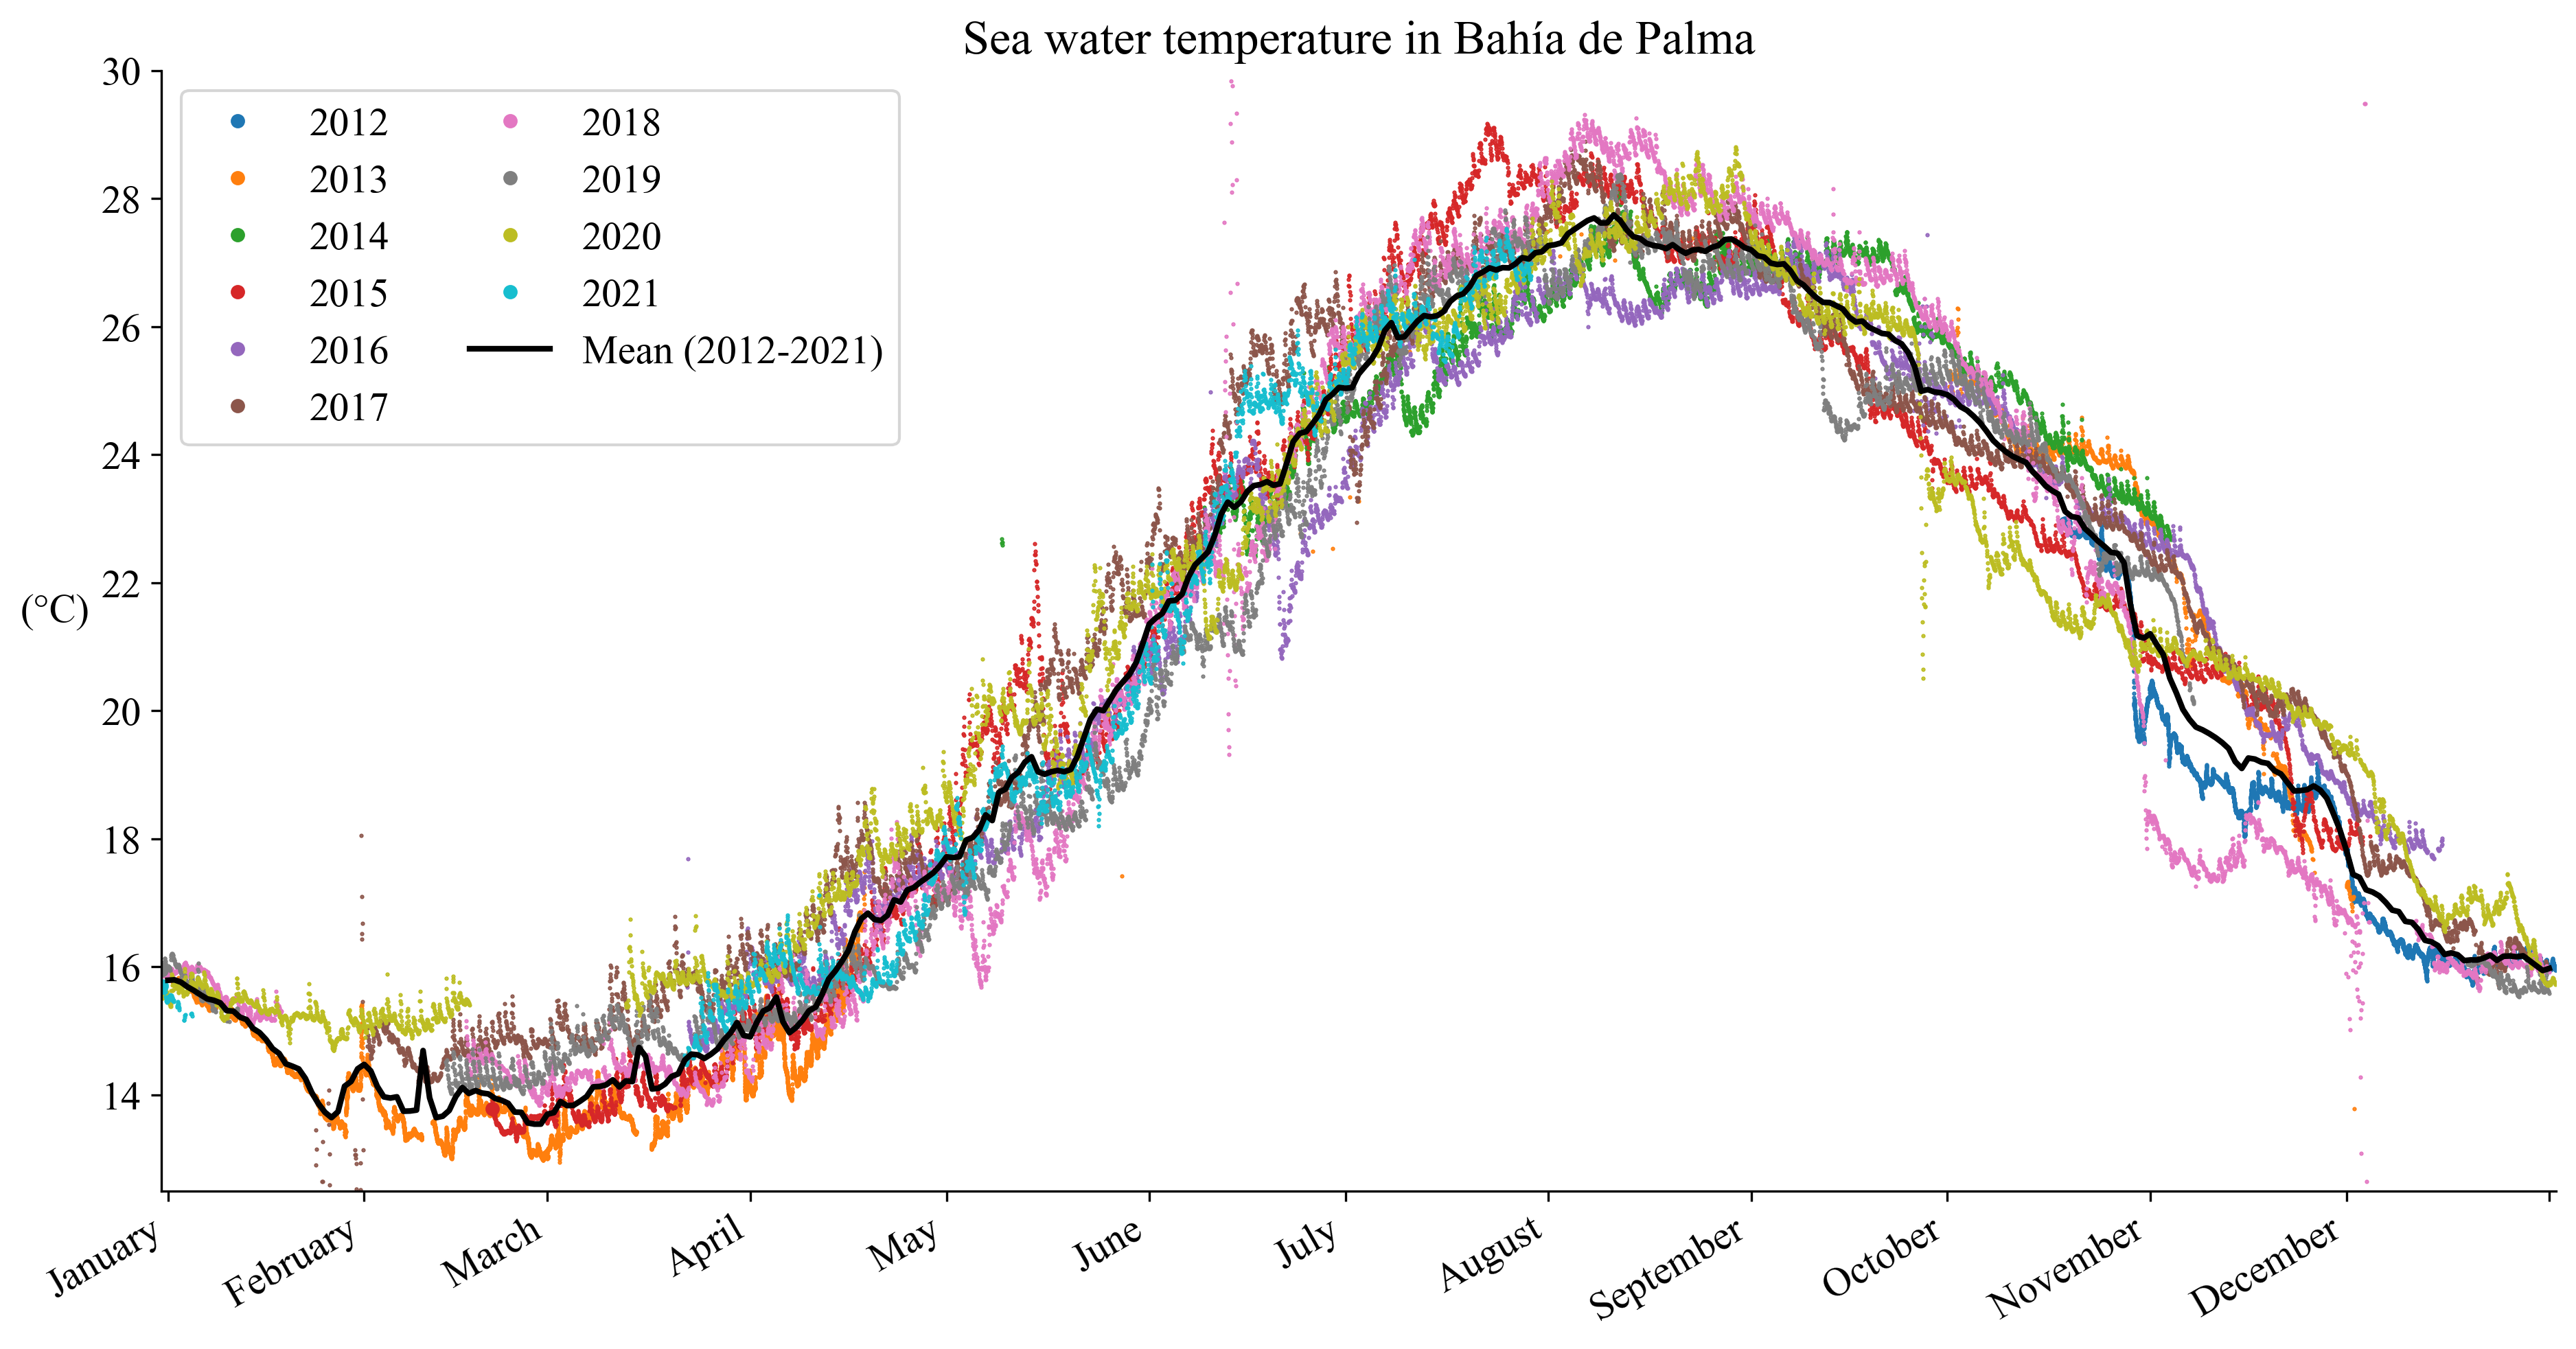

20142015201620172018201920202021

In [34]:
fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)
for year in 2012:2021
    @info("Working on year $(year)")
    goodyear = findall(yearvector .== year)
    ppp = ax.plot(daysyear[goodyear], T[goodyear], "o", ms=0.5)
    thecolor = ppp[1].get_color()
    ax.plot(daysyear[goodyear][1], T[goodyear][1], "o", ms=4, color=thecolor, label=year)

end

ax.plot(1:365., meanT, color="k", linewidth=2, label="Mean (2012-2021)")
lgnd = plt.legend(loc="upper left", scatterpoints=11, fontsize=14, ncol=2)

plt.title("Sea water temperature in Bahía de Palma", ha="center", rotation=0)
plt.ylabel("(°C)", ha="right", rotation=0)
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
plt.xlim(0., 366.)
plt.ylim(12.5, 30.)
plt.xticks(ticks=ndays[1:end], labels=monthnames)
fig.autofmt_xdate()
plt.savefig(joinpath(figdir, "./temperature_bahia_V2.jpg"), dpi=300, bbox_inches="tight")
plt.show()